In [1]:
%matplotlib inline
%load_ext tensorboard
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# from scipy.ndimage import binary_erosion
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchsummary import summary
from torchvision import transforms
import skimage
import skimage.io
import skimage.segmentation
import glob

import utils
import os
import zarr
import gunpowder as gp

from functools import partial

import scipy
import tqdm
from datetime import datetime
from scipy import ndimage
import csv

In [2]:
# train_data_path = "data/N3DHSIMDataset_01.n5"
# val_data_path = "data/N3DHSIMDataset_02.n5"
# train_data_path = "data/01.zarr"
# train_data_path = "data/old_small_mask/01.zarr"
train_data_path = "data/02.zarr"

za = zarr.open(train_data_path)
print(za.tree())

/
 ├── GT (128, 50, 332, 1007) float32
 ├── coords (124, 4) int64
 └── raw (128, 50, 332, 1007) uint8


In [3]:
# coordinates of the events in ground truth
coordinates = list()

with open("data/GT_02_metaphase.csv") as f:
    for i, line in enumerate(csv.reader(f)):
        if i == 0:
            continue
        coordinates.append([int(val) for val in line])

# fix for 1 based indexing
coordinates = np.asarray(coordinates) -1

# fix dims to TZYX
coordinates = coordinates[:, [0,-1,-2,-3]]
print(coordinates)

[[  0   3 173 341]
 [  0   3 168 959]
 [  0   3 185  15]
 [  0   7 172 301]
 [  0   7 207 322]
 [  0   9 209 291]
 [  0   9 206 667]
 [  0   9 201 755]
 [  0   9 153 765]
 [ 12  13 208 637]
 [  0  16 157 307]
 [  0  12 162 186]
 [  0  18 185 135]
 [ 13  18 157 520]
 [  0  24 211 819]
 [  0  24 154 639]
 [ 14  23 200 669]
 [  0  29 159 402]
 [  0  33 158 909]
 [  0  34 206 231]
 [  0  34 171 370]
 [  0  31 205 775]
 [  0  47 170 985]
 [  0  47 153 857]]


In [ ]:
# t = 0
# indices = np.where((coordinates[:, 0] == t) & (coordinates[:, 1] < 1000))
# print(coordinates[indices])

# fig, axes = plt.subplots(2, 1, figsize=(30, 15))
# axes[0].imshow(za['raw'][t,:].max(0), origin="lower")

# axes[1].imshow(za['GT'][t,:].max(0), origin="lower")

# # print(coordinates[indices][:,-1])
# axes[0].scatter(coordinates[indices][:,-1], coordinates[indices][:,-2], color='red', alpha=0.5)
# axes[1].scatter(coordinates[indices][:,-1], coordinates[indices][:,-2], color='red', alpha=0.5)

In [5]:
class Dataset_3DT(Dataset):
    def __init__(self, input_zarr_paths, out_size=(16, 128, 128), x_limit=[0, 1.0], output_mode=None,
                 roi_coordinates=None,
                 p_threshold=0.01):
        """ ZYX
        """
        ## expects zarr file with at least raw data
        
        self.input_zarr_paths = input_zarr_paths
#         self.datasource = zarr.open(self.input_z_arr_path)  # not actually used
#         self.data_shape = self.datasource['raw'].shape

        self.out_size = out_size
        self.output_mode = output_mode
        
        # use limits in the x dim to create train / validation dataset
        self.x_limit = x_limit
#         self.x_limit = (self.data_shape[-1] * np.asarray(x_limit)).astype(np.int)
#         self.x_limit = self.x_limit[0], np.diff(self.x_limit)[0]
#         print("x offset {}, x len {}".format(*self.x_limit))

        self.build_pipelines()
        
        self.build_augmentations()
        
        self.roi_coordinates = roi_coordinates
        
        self.p_threshold = p_threshold
        
    def build_augmentations(self):
        # basic augmentations
        # rotates only in xy planes
        
        self.augs = list()
        self.augs.append(partial(np.flip, axis=-1))
        self.augs.append(partial(np.flip, axis=-2))
        self.augs.append(partial(np.flip, axis=-3))
        self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-1, -2)))
#         self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-2, -3)))
#         self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-3, -1)))
        self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-2, -1)))
#         self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-3, -2)))
#         self.augs.append(partial(np.rot90, k=np.random.randint(1, 3), axes=(-1, -3)))


    def build_pipelines(self):
        self._raw = gp.ArrayKey('raw')
        self._ground_truth = gp.ArrayKey('GT')
#         self.datasources = list()
        self.pipelines = list()
        self.pipelines_without_random_location = list()
        for path in self.input_zarr_paths:
            assert 'raw' in zarr.open(path), "'raw' key require but not found in target zarr file"
            assert 'GT' in zarr.open(path), "'GT' key require but not found in target zarr file"
            
            raw_data_shape = zarr.open(path)['raw'].shape
            print(raw_data_shape)
            self.raw_data_shape = raw_data_shape
            
            x_limit = (raw_data_shape[-1] * np.asarray(self.x_limit)).astype(np.int)
            x_limit = x_limit[0], np.diff(x_limit)[0]
            print("file [{}]: x offset {}, x len {}".format(path, *x_limit))
            
            raw_source = gp.ZarrSource(
                path,
                {self._raw: 'raw', },
                {self._raw: gp.ArraySpec(gp.Roi((0, 0,
                                                 0, # crop on y axis based on prior knowledge that almost no events occur outise
                                                 x_limit[0]),
                                                (raw_data_shape[0],raw_data_shape[1],
                                                 raw_data_shape[2],
                                                 x_limit[1])),
                                         interpolatable=True,
    #                                      voxel_size=(1, 200, 125, 125)
                                        )},
                )
            
            gt_source = gp.ZarrSource(
                path,
                {self._ground_truth: 'GT', },
                {self._ground_truth: gp.ArraySpec(gp.Roi((0, 0,
                                                          0,
                                                          x_limit[0]), # crop on y axis based on prior knowledge that almost no events occur outise
                                                         (raw_data_shape[0], raw_data_shape[1],
                                                          raw_data_shape[2],
                                                          x_limit[1])),
                                                  interpolatable=True,
    #                                               voxel_size=(1, 200, 125, 125)

                                                 )},
                )
            
            comb_source = (raw_source, gt_source) + gp.MergeProvider()        

            random_location = gp.RandomLocation()

            random_sample = comb_source + random_location
            
            self.pipelines.append(random_sample)
            self.pipelines_without_random_location.append(comb_source)
            
        self.basic_request = gp.BatchRequest()
        self.basic_request[self._raw] = gp.Roi((0, 0, 0, 0),
                                               (1, self.out_size[0], self.out_size[1], self.out_size[2]),
                                              )
        self.basic_request[self._ground_truth] = gp.Roi((0, 0, 0, 0),
                                                        (1, self.out_size[0], self.out_size[1], self.out_size[2]),
                                                       )
    def override_request_from_coordinates(self):
        self.basic_request = gp.BatchRequest()
        
        rnd_index =  np.random.randint(0, high=self.roi_coordinates.shape[0])
#         print(rnd_index)
        
#         print(self.roi_coordinates)
#         print(rnd_index)
        roi = self.roi_coordinates[rnd_index].copy()
        
#         print(roi)
        
        roi[1] = roi[1] - self.out_size[0]//2
        roi[2] = roi[2] - self.out_size[1]//2
        roi[3] = roi[3] - self.out_size[2]//2
        
        # always centering is probably a bad idea, so add some translations
        roi[1] = roi[1] + np.random.uniform(-1, 1) * self.out_size[0] * 0.3
        roi[2] = roi[2] + np.random.uniform(-1, 1) * self.out_size[1] * 0.3
        roi[3] = roi[3] + np.random.uniform(-1, 1) * self.out_size[2] * 0.3
        
        # protect out of bounds
        roi[1] = np.clip(roi[1], 0, self.raw_data_shape[1]-self.out_size[0]-1)
        roi[2] = np.clip(roi[2], 0, self.raw_data_shape[2]-self.out_size[1]-1)
        roi[3] = np.clip(roi[3], 0, self.raw_data_shape[3]-self.out_size[2]-1)
#         print(roi)
        # ignores x_limit...
    
        self.actual_offset = roi - self.roi_coordinates[rnd_index]
#         print(self.actual_offset)
        
        self.basic_request[self._raw] = gp.Roi(roi,
                                               (1, self.out_size[0], self.out_size[1], self.out_size[2]))
        self.basic_request[self._ground_truth] = gp.Roi(roi,
                                                        (1, self.out_size[0], self.out_size[1], self.out_size[2]))
        
    def modify_ground_truth(self, ground_truth):
        # modifications applied per cropped roi, so may have werid edge effects
#         print(ground_truth.shape)
        if self.output_mode is None:
            return ground_truth
        elif self.output_mode == "binary":
            return ground_truth.astype(bool)
        elif self.output_mode == "dt":
            return scipy.ndimage.distance_transform_edt(ground_truth)
        elif self.output_mode == "sdt":
            ground_truth = ground_truth.astype(bool)
            positives = ndimage.distance_transform_edt(ground_truth)
            negatives = -ndimage.distance_transform_edt(~ground_truth)
            return positives + negatives
        elif self.output_mode == "centroid" or self.output_mode == "centroid_gauss":
#             print(scipy.ndimage.label(ground_truth)[0].shape)
            labels, num_features = ndimage.label(ground_truth)
#             print(num_features)
            centroids = ndimage.center_of_mass(np.ones_like(ground_truth),
                                                              labels,
                                                            np.arange(1, num_features+1))
#             print(centroids)
            new_ground_truth = np.zeros(ground_truth.shape, dtype=int)
            for pt in centroids:
                new_ground_truth[np.floor(pt[0]).astype(int),
                                 np.floor(pt[1]).astype(int),
                                 np.floor(pt[2]).astype(int),
                                 np.floor(pt[3]).astype(int),
                                ] = 1
            if self.output_mode == "centroid":
                return new_ground_truth
            else:
                sig = 8
                n_dim = len(new_ground_truth.shape)
#                 print(n_dim)
                new_ground_truth = ndimage.gaussian_filter(new_ground_truth.astype(float), sig,
                                                                mode='constant', cval=0)
                new_ground_truth *= sig**n_dim * np.power(2 * np.pi, n_dim * 0.5) # should be normalized properly?
                return new_ground_truth
        elif self.output_mode == "boundaries":
            dilated_mask = ndimage.binary_dilation(ground_truth.astype(bool),)
            return dilated_mask.astype(int) - ground_truth.astype(bool).astype(int)
        elif self.output_mode == "gaussian_filter":
            sig = 4
            n_dim = ground_truth.ndim
#             print(n_dim)
            new_ground_truth = ndimage.gaussian_filter(ground_truth.astype(float), sig,
                                                                mode='constant', cval=0)
            new_ground_truth *= sig**n_dim * np.power(2 * np.pi, n_dim * 0.5)
            return new_ground_truth
        elif self.output_mode == "coordinates":
            # for testing only? Will only draw the on-target ground truth, neighbours are ignored
            sig = 8
            n_dim = ground_truth.ndim
            new_ground_truth = np.zeros(ground_truth.shape, dtype=float)
            t,z,y,x = -self.actual_offset
            new_ground_truth[t,z,y,x] = 1.
            new_ground_truth = ndimage.gaussian_filter(new_ground_truth, sig,
                                                                mode='constant', cval=0)
            new_ground_truth *= sig**n_dim * np.power(2 * np.pi, n_dim * 0.5) 
            return new_ground_truth
            
        else:
            raise Exception("{} is an unrecognised output mode.".format(self.output_mode))

    def __getitem__(self, key, ):
        random_pipelines_index = np.random.randint(0, len(self.pipelines))
        # equal chance of picking from any file, does not balance for difference in bg between file
#         print("Picking sample from {}".format(self.input_zarr_paths[random_pipelines_index]))
        
        if self.roi_coordinates is None:
            pipeline = self.pipelines[random_pipelines_index]
            
            with gp.build(pipeline):
                good_data = False            
                while not good_data:
                    batch = pipeline.request_batch(self.basic_request)
    #                 print(batch[self._ground_truth].data.astype(bool).sum()/batch[self._ground_truth].data.astype(bool).size)
                    good_data = (batch[self._ground_truth].data>0).sum() \
                                / batch[self._ground_truth].data.astype(bool).size > self.p_threshold # basically rejector
        else:
            pipeline = self.pipelines_without_random_location[random_pipelines_index]
        
            self.override_request_from_coordinates()
            with gp.build(pipeline):
                batch = pipeline.request_batch(self.basic_request)

        data_roi, ground_truth_roi = batch[self._raw].data, batch[self._ground_truth].data    
    
        # adding noise to data
#         data_roi = np.random.normal(data_roi, 5, size=data_roi.shape)
#         data_roi = np.random.poisson(data_roi, data_roi.shape)
    
        # adding augmentations to both data and ground truth
        for aug in self.augs:
            if np.random.rand() > 0.5:
                data_roi = aug(data_roi)
                ground_truth_roi = aug(ground_truth_roi)
                
        # normalize
        data_roi = data_roi - data_roi.min()
        data_roi = data_roi / (data_roi.max() * np.random.uniform(0.8, 1.2))

        # change output type
        ground_truth_roi = self.modify_ground_truth(ground_truth_roi)
                
        return data_roi.copy(), ground_truth_roi.copy()

    
    def __len__(self):
        # completely arbitrary for now
        return 32*4

In [6]:
# using left half of training dataset for validation
train_dataset = Dataset_3DT([train_data_path], out_size=(32,96, 96),
                            x_limit=[0, 1.0], output_mode=None, roi_coordinates=coordinates, p_threshold=0.1)
print(len(train_dataset))
# train_dataset[0]

# val_dataset = Dataset_3DT(val_data_path, out_size=(32, 64, 64))
# print(len(val_dataset))
# # val_dataset[0]

# # using right half of training dataset for validation
# val_dataset = Dataset_3DT([train_data_path], out_size=(32, 64, 64),
#                           x_limit=[0.5, 1.0], output_mode="sdt", roi_coordinates=None, p_threshold=0.1)
# print(len(val_dataset))

(128, 50, 332, 1007)
file [data/02.zarr]: x offset 0, x len 1007
128


In [7]:
# this data loader will serve 8 images in a "mini-batch" at a time
train_dataloader = DataLoader(train_dataset, batch_size=32,)
# val_dataloader = DataLoader(val_dataset, batch_size=32,)

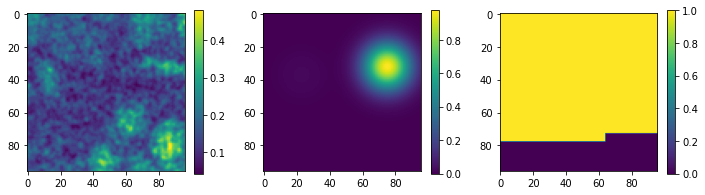

In [8]:
def plot_slice_from_volume(data, mask):
    fig, axes = plt.subplots(1, 3, figsize=(12,3))
    z = np.argmax(mask.max(axis=(-2,-1)), axis=1)[0] # axis 1
#     print(z)
    _im = axes[0].imshow(data[0, z, ...])
    plt.colorbar(_im, ax = axes[0])
    _im = axes[1].imshow(mask[0, z, ...])
    plt.colorbar(_im, ax = axes[1])
#     print(data.dtype, mask.dtype)
    _im = axes[2].imshow(mask[0, z, ...]>0)
    plt.colorbar(_im, ax = axes[2])
    
def plot_slice_from_volume_maxproj(data, mask):
    fig, axes = plt.subplots(1, 3, figsize=(12,3))
    
    _im = axes[0].imshow(data[0, ...].max(0))
    plt.colorbar(_im, ax = axes[0])
    _im = axes[1].imshow(mask[0, ...].max(0))
    plt.colorbar(_im, ax = axes[1])
#     print(data.dtype, mask.dtype)
    _im = axes[2].imshow(mask[0, ...].max(0)>0)
    plt.colorbar(_im, ax = axes[2])
    
for data, ground_truth in train_dataset:
    break

plot_slice_from_volume(data, ground_truth)

# for data, val in val_dataset:
#     break

# plot_slice_from_volume_maxproj(data, val)

In [9]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    print("! GPU available. Using CPU")
    device.torch.device('cpu')

In [10]:
class Unet3D(torch.nn.Module):
    
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
                             nn.GroupNorm(in_channels, in_channels),
                             nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU(),
                             nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU())       


    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels,
                                kernel_size=2, stride=2)
    
    def __init__(self, depth=5, final_activation=None):
        super(Unet3D, self).__init__()
        self.depth = depth
        
        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(final_activation, nn.Module), "Activation must be torch module"
            
        self.activation = final_activation
        
        # modules of the encoder path
        self.encoder = nn.ModuleList()
    
        # modules of the encoder path
        self.decoder = nn.ModuleList()
        
        # the upsampling layers
        self.upsamplers = nn.ModuleList()
        
        first_layer_out_channels = 16
        
        for i in np.arange(self.depth):
            self.encoder.append(self._conv_block(1 if i == 0 else 2**(i-1) * first_layer_out_channels,
                                                 2**i * first_layer_out_channels))
        
            self.upsamplers.append(self._upsampler(2**(self.depth-i)*first_layer_out_channels,
                                                   2**(self.depth-i-1)*first_layer_out_channels))
        
            self.decoder.append(self._conv_block(2**(self.depth-i)*first_layer_out_channels,
                                                 2**(self.depth-i-1)*first_layer_out_channels))
        
        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool3d(2) for _ in range(self.depth)])
        
        self.base = self._conv_block(int(2**(self.depth-1) * first_layer_out_channels),
                                     (2**(self.depth) * first_layer_out_channels))
        
        self.dropout = nn.Dropout3d(0.25)
        
        self.out_conv = nn.Conv3d(first_layer_out_channels, 1, kernel_size=1)
        
    def forward(self, x):
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)
            x = self.dropout(x)

#         apply base
        x = self.base(x)
        x = self.dropout(x)
        
# #         # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))
            x = self.dropout(x)
        
#         # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)

        return x




# change depth, roi dimensions or batch size to fit in memory
summary(Unet3D(depth=5).to(device), ( 1, 32, 64, 64), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         GroupNorm-1        [32, 1, 32, 64, 64]               2
            Conv3d-2       [32, 16, 32, 64, 64]             448
              ReLU-3       [32, 16, 32, 64, 64]               0
            Conv3d-4       [32, 16, 32, 64, 64]           6,928
              ReLU-5       [32, 16, 32, 64, 64]               0
         MaxPool3d-6       [32, 16, 16, 32, 32]               0
         Dropout3d-7       [32, 16, 16, 32, 32]               0
         GroupNorm-8       [32, 16, 16, 32, 32]              32
            Conv3d-9       [32, 32, 16, 32, 32]          13,856
             ReLU-10       [32, 32, 16, 32, 32]               0
           Conv3d-11       [32, 32, 16, 32, 32]          27,680
             ReLU-12       [32, 32, 16, 32, 32]               0
        MaxPool3d-13        [32, 32, 8, 16, 16]               0
        Dropout3d-14        [32, 32, 8,

In [11]:
# attempt to fix werid image display on tensorboard
    
def normalize_to_int8(img):
    img -= img.min()
    return np.round(img / img.max() * 255)

def normalize_to_01(img):
    img = img.float()
    img = img - img.min()
    return img / img.max()

In [12]:
# apply training for one epoch
def train(model, loader, optimizer, loss_function,
          epoch, log_interval=100, log_image_interval=20, tb_logger=None):

    model.train()
    model.requires_grad_(True)
    
    # iterate over the batches of this epoch
    for batch_id, (x, y) in enumerate(loader):
        # move input and target to the active device (either cpu or gpu)
        x, y = x.to(device), y.to(device)
        
        # zero the gradients for this iteration
        optimizer.zero_grad()
        
        # apply model and calculate loss
        pred = model(x.float())
        
        # backpropagate the loss and adjust the parameters
        loss = loss_function(pred, y.float())
        loss.backward()
        optimizer.step()
        
        # log to console
        if batch_id % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_id * len(x),
                  len(loader.dataset),
                  100. * batch_id / len(loader), loss.item()))

       # log to tensorboard
        if tb_logger is not None:
            step = epoch * len(loader) + batch_id
            tb_logger.add_scalar(tag='train_loss', scalar_value=loss.item(), global_step=step)
            # check if we log images in this iteration
            if step % log_image_interval == 0:
                z = np.random.randint(0, x.shape[2])
                tb_logger.add_images(tag='input',
                                     img_tensor=normalize_to_01(x.to('cpu')[:, : , z, ...]).detach(), global_step=step)
                tb_logger.add_images(tag='target',
                                     img_tensor=normalize_to_01(y.to('cpu')[:, :, z, ...]).detach(), global_step=step)
                tb_logger.add_images(tag='prediction',
                                     img_tensor=normalize_to_01(pred.to('cpu')[:, :, z, ...].detach()), global_step=step)

In [13]:
# run validation after training epoch
def validate(model, loader, loss_function, metric, step=None, tb_logger=None):
#     set model to eval mode
    model.eval()
    # running loss and metric values
    val_loss = 0
    val_metric = 0
    
    # disable gradients during validation
    with torch.no_grad():
#     model.requires_grad_(False)
        
        # iterate over validation loader and update loss and metric values
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x.float())
            val_loss += loss_function(pred, y.float()).item()
            val_metric += metric(pred, y.float()).item()
            
    
    # normalize loss and metric
    val_loss /= len(loader)
    val_metric /= len(loader)
    
    if tb_logger is not None:
        assert step is not None, "Need to know the current step to log validation results"
        tb_logger.add_scalar(tag='val_loss', scalar_value=val_loss, global_step=step)
        tb_logger.add_scalar(tag='val_metric', scalar_value=val_metric, global_step=step)
        # we always log the last validation images
        z = np.random.randint(0, x.shape[2])
        tb_logger.add_images(tag='val_input',
                             img_tensor=normalize_to_01(x.to('cpu')[:, : , z, ...]).detach(), global_step=step)
        tb_logger.add_images(tag='val_target',
                             img_tensor=normalize_to_01(y.to('cpu')[:, : , z, ...]).detach(), global_step=step)
        tb_logger.add_images(tag='val_prediction',
                             img_tensor=normalize_to_01(pred.to('cpu')[:, : , z, ...]).detach(), global_step=step)
        
    print('\nValidate: Average loss: {:.4f}, Average Metric: {:.4f}\n'.format(val_loss, val_metric))

In [14]:
def save(target_path, epoch):
    torch.save({
    'epoch': epoch,
    'model_state_dict': net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
#             'loss': LOSS,
    }, target_path)


In [15]:
# save("checkpoints/chk_point_sb01_178", 178)

In [16]:
# sorensen dice coefficient implemented in torch
# the coefficient takes values in [0, 1], where 0 is
# the worst score, 1 is the best score
class DiceCoefficient(nn.Module,):
    def __init__(self, eps=1e-6, as_lost_func=False):
        super().__init__()
        self.eps = eps
        self.as_lost_func = as_lost_func
        
    # the dice coefficient of two sets represented as vectors a, b ca be 
    # computed as (2 *|a b| / (a^2 + b^2))
    def forward(self, prediction, target):
        intersection = (prediction * target).sum()
        denominator = (prediction * prediction).sum() + (target * target).sum()
        out = (2 * intersection / denominator.clamp(min=self.eps))
        if self.as_lost_func:
            out *= -1
        return out

In [17]:
def setup_network(load_path=None):
    net = Unet3D(depth=5,)
    
    # use adam optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    
    # MSE loss
    loss_function = nn.MSELoss()
    
    metric = DiceCoefficient()
    
    if not load_path is None:
        checkpoint = torch.load(load_path)
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        net.eval()
    
    return net, optimizer, loss_function, metric

net, optimizer, loss_function, metric = setup_network()
# net, optimizer, loss_function = setup_network("chk_point_0")

In [18]:
# start a tensorboard writer
%tensorboard --logdir runs

In [ ]:
def train_and_validate(net, train_dataloader, val_dataloader, optimizer, loss_function, n_epochs=100, logger=None, checkpoints=None):
    # during the training you can inspect the 
    # predictions in the tensorboard
    
    net.to(device)
    
    for epoch in range(n_epochs):
        # train
        train(net, train_dataloader, optimizer, loss_function, epoch, tb_logger=logger)
        step = epoch * len(train_dataloader.dataset)
        # validate
        validate(net, val_dataloader, loss_function, metric, epoch, tb_logger=logger)
        if epoch in checkpoints:
            save(checkpoints[epoch], epoch)
            print("checkpoint, epoch {} saved at {}".format(epoch, checkpoints[epoch]))
            
train_and_validate(net,
                   train_dataloader,
                   train_dataloader,
                   optimizer, loss_function, 1000000,
                   SummaryWriter("runs/3D_Unet_{}".format(datetime.now().strftime("%Y%M%d_%H:%M:%S"))),
                   {i : "checkpoints/chk_point_SB02_sim_pts_01_{}".format(i) for i in np.arange(20, 100000000, 20)})

Train Epoch: 0 [0/128 (0%)]	Loss: 0.029680

Validate: Average loss: 0.0092, Average Metric: 0.0249

Train Epoch: 1 [0/128 (0%)]	Loss: 0.010602

Validate: Average loss: 0.0077, Average Metric: 0.1842

Train Epoch: 2 [0/128 (0%)]	Loss: 0.010708

Validate: Average loss: 0.0070, Average Metric: 0.2106

Train Epoch: 3 [0/128 (0%)]	Loss: 0.008408

Validate: Average loss: 0.0059, Average Metric: 0.2710

Train Epoch: 4 [0/128 (0%)]	Loss: 0.007206

Validate: Average loss: 0.0057, Average Metric: 0.4037

Train Epoch: 5 [0/128 (0%)]	Loss: 0.007322

Validate: Average loss: 0.0056, Average Metric: 0.3220

Train Epoch: 6 [0/128 (0%)]	Loss: 0.005601

Validate: Average loss: 0.0057, Average Metric: 0.4510

Train Epoch: 7 [0/128 (0%)]	Loss: 0.007337

Validate: Average loss: 0.0054, Average Metric: 0.3772

Train Epoch: 8 [0/128 (0%)]	Loss: 0.006868

Validate: Average loss: 0.0054, Average Metric: 0.3519

Train Epoch: 9 [0/128 (0%)]	Loss: 0.006560

Validate: Average loss: 0.0051, Average Metric: 0.4322




Validate: Average loss: 0.0018, Average Metric: 0.8483

Train Epoch: 80 [0/128 (0%)]	Loss: 0.002322

Validate: Average loss: 0.0015, Average Metric: 0.8861

checkpoint, epoch 80 saved at checkpoints/chk_point_SB02_sim_pts_01_80
Train Epoch: 81 [0/128 (0%)]	Loss: 0.002268

Validate: Average loss: 0.0016, Average Metric: 0.8431

Train Epoch: 82 [0/128 (0%)]	Loss: 0.002192

Validate: Average loss: 0.0016, Average Metric: 0.8621

Train Epoch: 83 [0/128 (0%)]	Loss: 0.002262

Validate: Average loss: 0.0015, Average Metric: 0.8826

Train Epoch: 84 [0/128 (0%)]	Loss: 0.002062

Validate: Average loss: 0.0017, Average Metric: 0.8515

Train Epoch: 85 [0/128 (0%)]	Loss: 0.002194


In [ ]:
def plot_predictions(net, dataloader):
    for batch_id, (x, y) in enumerate(dataloader):
        num_to_show = min([x.shape[0], 8])
        fig, axes = plt.subplots(num_to_show, 5, figsize=(16, 3*num_to_show))    
    #     print(x.dtype, y.dtype)
        x, y = x.to(device), y.double().to(device)
    #     print(x.type(), y.type())
        pred = net(x.float())

        z = y.sum((-2, -1)).argmax(2).squeeze()
        for i in np.arange(num_to_show):
            axes[i, 0].imshow(x[i,0,z[i],...].cpu().detach())
            axes[i, 0].set_title('data')
            
            _im = axes[i, 1].imshow(y[i,0,z[i],...].cpu().detach())
            plt.colorbar(_im, ax=axes[i,1])
            axes[i, 1].set_title('ground truth')
            
            _im = axes[i, 2].imshow(y[i,0,z[i],...].cpu().detach()>0)
            axes[i, 2].set_title('ground truth masked')
            
            _im = axes[i, 3].imshow(pred[i,0,z[i],...].cpu().detach())
            plt.colorbar(_im, ax=axes[i,3])
            axes[i, 3].set_title('predicted')
            
            _im = axes[i, 4].imshow(pred[i,0,z[i],...].cpu().detach()>0)
            axes[i, 4].set_title('predicted masked')

        break

In [ ]:
plot_predictions(net, train_dataloader)

In [ ]:
plot_predictions(net, val_dataloader)

In [ ]:
sdeewfse

In [ ]:
# test_data_path = "data/N3DHSIMDataset_01.n5"
# test_data_key = "raw"

# model_prediction_path = "data/N3DHSIMDataset_01_pred.n5"
# model_prediction_key = "sdt"

# # pred_file = zarr.open(model_prediction_path)
# # pred_file[model_prediction_key] = np.zeros(zarr.open(test_data_path)[test_data_key].shape)

# # print(pred_file[model_prediction_key])

In [ ]:
# def predict_complete_dataset(net, source_path, source_key, target_path, target_key,
#                             model_input_shape):
    
#     source_array = zarr.open(source_path)[source_key]
#     target_zarray = zarr.open(target_path)
#     target_zarray[target_key] = np.zeros(source_array.shape)
#     target_array = target_zarray[target_key]
    
#     print(model_input_shape)
#     # 8, 1, 32, 64, 64

#     # predicted_volume = np.zeros(raw_data.shape)

#     def get_actual_slice(start, length, step):
#         stop = min(length, start+step)
#         start = stop - step
#         return slice(start, stop)

#     net.double()
#     net.cuda()
    
#     # change this to resume previous prediction
#     t_start = 0
    
#     for t in np.arange(t_start, source_array.shape[0], step=model_input_shape[0]):
# #         print(t)
#     #     t1 = min(raw_data.shape[0], t+8)
#     #     t0 = t1 - 8
#         t_slice = get_actual_slice(t, source_array.shape[0], model_input_shape[0])
#         print(t0, t1)
#         for z in tqdm.tqdm(np.arange(source_array.shape[1], step=model_input_shape[2])):
#             z_slice = get_actual_slice(z, source_array.shape[1], model_input_shape[2])

#             for y in np.arange(source_array.shape[2], step=model_input_shape[3]):
#                 y_slice = get_actual_slice(y, source_array.shape[2], model_input_shape[3])

#                 for x in np.arange(source_array.shape[3], step=model_input_shape[4]):
#                     x_slice = get_actual_slice(x, source_array.shape[3], model_input_shape[4])

#                     crop = torch.as_tensor(raw_data[t_slice, z_slice, y_slice, x_slice].astype(np.double),
#                                                     device=torch.device('cuda'),)
#                     crop = crop.unsqueeze(1)

#                     target_array[t_slice, z_slice, y_slice, x_slice] = net(crop).cpu().detach()[:,0,...]

